# Classification

### Importing libraries 

In [4]:
import pandas  as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime as dt 
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, precision_score, roc_auc_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import optuna
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

### Exploanatory Data Analysis

Let's start by creating a correlation matrix. <br>None of the variables are highly correlated with each other (assumed threshold >|0.7|). <br>In particular, it is good information that the predicted variable has only very weak correlation coefficients. 

Text(0.5, 1.0, 'Correlation Heatmap')

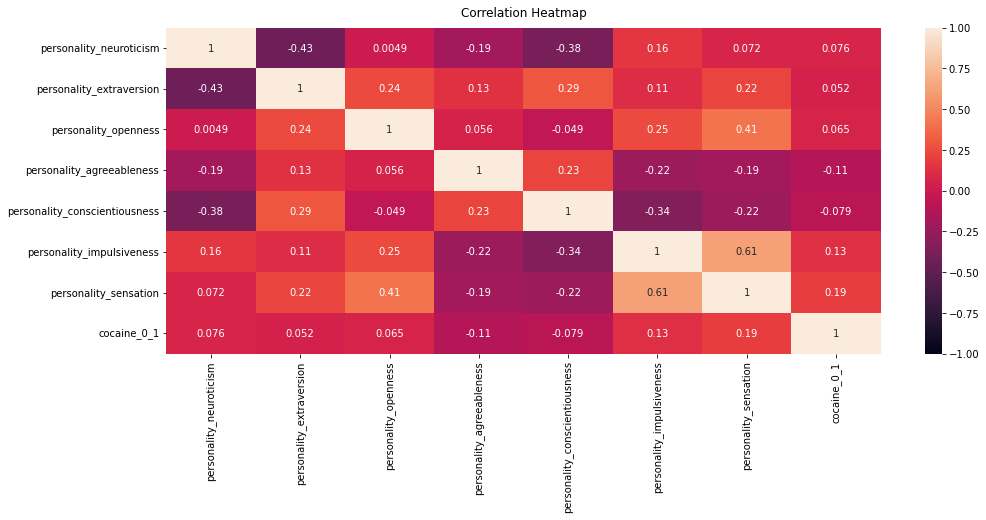

In [5]:
drugs = pd.read_csv('drugs_train.csv')
plt.figure(figsize=(16, 6))
drugs['cocaine_0_1'] = np.where(drugs['consumption_cocaine_last_month'] == 'Yes', 1,0)
heatmap = sns.heatmap(drugs.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=11)

### Data Preprocessing

Below we have defined functions to preprocess the data, based on the conclusions we have drawn from EDA. 
These will be as follows: 
- creating dummie variables based on the columns: age, ethnicity, country, gender, consumption_cocaine_last_month
- create ordinal variables based on the columns describing consumption of drugs (of course without the predicted variable)
- scaling continuous variables using RobustScaler()
- creating a function that allows easy validation of the created models 


In [11]:
def getting_dummies(drugs):
    drugs['tmp'] = range(0,drugs.shape[0])
    t1 = pd.get_dummies(drugs['age'])
    t1['tmp'] = range(0,drugs.shape[0])
    drugs = pd.merge(drugs, t1, on = ['tmp'])

    t1 = pd.get_dummies(drugs['country'])
    t1['tmp'] = range(0,drugs.shape[0])
    drugs = pd.merge(drugs, t1, on = ['tmp'])
    try:
        drugs['Other_country'] = drugs['Other'] + drugs['Ireland'] + drugs['Canada']

        t1 = pd.get_dummies(drugs['ethnicity'])
        t1['tmp'] = range(0,drugs.shape[0])
        drugs = pd.merge(drugs, t1, on = ['tmp'])
        drugs['Other_y'] = drugs['Other_y'] + drugs['White']

        drugs = drugs.drop(columns = ['tmp', 'age', 'country', 'ethnicity','Ireland', 'Canada', 'Other_x' , 'White'])
    except:
        drugs['Other_country'] = drugs['Other'] + drugs['Ireland'] 

        t1 = pd.get_dummies(drugs['ethnicity'])
        t1['tmp'] = range(0,drugs.shape[0])
        drugs = pd.merge(drugs, t1, on = ['tmp'])

        drugs = drugs.drop(columns = ['tmp', 'age', 'country', 'ethnicity','Ireland',  'Other_x' ])

    return (drugs)

def getting_ordinals(drugs):
    
    lst = ['consumption_alcohol', 'consumption_amphetamines', 'consumption_caffeine',
            'consumption_cannabis', 'consumption_chocolate',
            'consumption_mushrooms', 'consumption_nicotine']
    consDict = {'never used':0,  'used over a decade ago':1,
       'used in last decade':2,'used in last year':3, 'used in last month':4, 'used in last week' : 5, 'used in last day' : 6}

    eduDict = {'Left school before 16 years' : 0, 'Left school at 16 years' : 0, 'Left school at 17 years':0, 'Left school at 18 years' : 0, 
               'Some college or university, no certificate or degree':1, 'Professional certificate/ diploma':2 ,'University degree':3, 'Masters degree':4, 
               'Doctorate degree' : 5}


    for cols in lst:
        drugs[cols]=drugs[cols].map(consDict)
    
    drugs['education'] = drugs['education'].map(eduDict)
    return(drugs)

def gender_dummy(drugs):
    drugs['female'] = np.where(drugs['gender'] == 'female', 1, 0) 
    drugs = drugs.drop(columns=['gender', 'id'])
    return (drugs)

def expl_var_dummy(drugs):
    drugs['consumption_cocaine_last_month'] = np.where(drugs['consumption_cocaine_last_month'] == 'Yes', 1, 0) 
    return (drugs)

def scalling(drugs):
    scaled_features = drugs.copy()

    col_names = ['personality_neuroticism', 'personality_extraversion',
                'personality_openness', 'personality_agreeableness',
                'personality_conscientiousness', 'personality_impulsiveness',
                'personality_sensation']
    features = scaled_features[col_names]

    scaler = RobustScaler().fit(features.values)
    features = scaler.transform(features.values)

    scaled_features[col_names] = features

    return(scaled_features)
    
# def our_metrics(y_test, preds):
#      print(f'Balanced Accuracy:', balanced_accuracy_score(y_test, preds), 
#           '\nconfusion:\n', confusion_matrix(y_test, preds),
#           '\nprecision:', precision_score(y_test, preds) ,
#           '\naccuracy:', accuracy_score(y_test, preds), 
#           '\nrecall:', recall_score(y_test, preds),
#           '\nauroc:', roc_auc_score(y_test, preds) )
def our_metrics(y_test, preds):
     print(f'Balanced Accuracy:', balanced_accuracy_score(y_test, preds), 
          '\nconfusion:\n', confusion_matrix(y_test, preds),
         )

drugs = pd.read_csv('drugs_train.csv')

drugs = getting_dummies(drugs)
drugs = getting_ordinals(drugs)
drugs = gender_dummy(drugs)
drugs = expl_var_dummy(drugs)
drugs = scalling(drugs)
x_train, x_test, y_train, y_test = train_test_split(drugs.loc[:,drugs.columns!='consumption_cocaine_last_month'], drugs.consumption_cocaine_last_month, test_size=0.15, stratify= drugs.consumption_cocaine_last_month)

oversample = SMOTE()
X, y = oversample.fit_resample(x_train, y_train)
counter_a = Counter(y)
print('SMOTE y distribution:', counter_a)

x_trainSM, x_testSM, y_trainSM, y_testSM = train_test_split(X,y, test_size=0.05)
counter = Counter(y_test)
print('Virgin y distribution:' , counter)


SMOTE y distribution: Counter({0: 1167, 1: 1167})
Virgin y distribution: Counter({0: 206, 1: 19})


## Model Estimation

Balanced Accuracy: 0.7487225344915687 
confusion:
 [[135  71]
 [  3  16]]


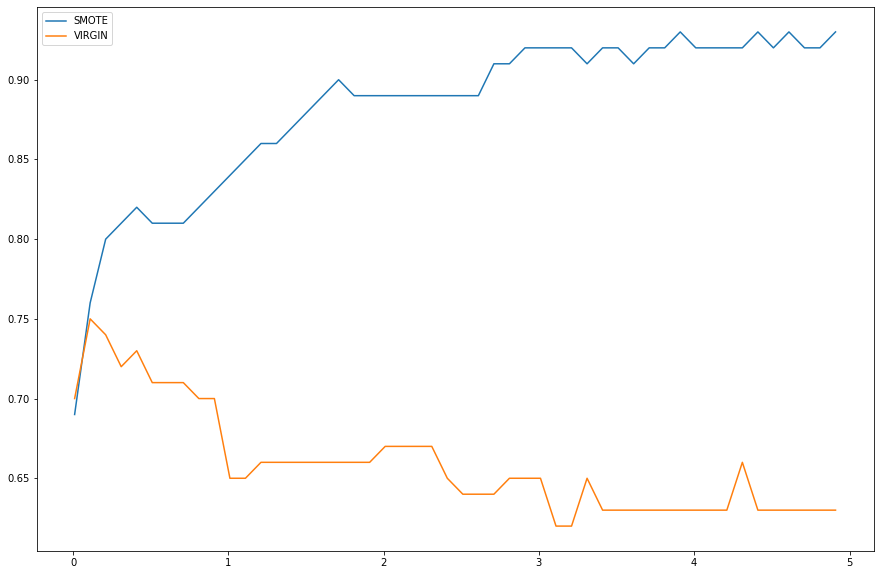

In [13]:
#SVM 

c_param = np.arange(0.01, 5, 0.1) # [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 2.5]
sm = []
vg = []
for c in c_param:
    
    
    kf = KFold(n_splits=5)
    ba_smote = []
    ba_virg = []
    
    clf = SVC(C=c,  kernel='rbf', max_iter=-1, probability=True, tol=0.1,random_state= 13,  verbose=False)

    for train, test in kf.split(drugs.index.values):
        
        clf.fit(x_trainSM, y_trainSM)
        
        #Over-sampled DS 
        prob = clf.predict(x_testSM)
        ba_smote.append(balanced_accuracy_score(y_testSM, prob))

        #Virgin DS
        prob = clf.predict(x_test)
        ba_virg.append(balanced_accuracy_score(y_test, prob))
    sm.append(np.round(np.mean(ba_smote), 2))
    vg.append(np.round(np.mean(ba_virg), 2))
        
    
    

best = dict(zip(vg, c_param))
vg_m = max(list(best.keys()))

clf = SVC(C=best[vg_m],  kernel='rbf', max_iter=-1, probability=True, tol=0.1, random_state= 13, verbose=False)
clf.fit(x_trainSM, y_trainSM)
prob = clf.predict(x_test)
our_metrics(y_test, prob)


my_dict = dict(x=c_param,y=sm,z=vg)
data = pd.DataFrame(my_dict)

plt.figure(figsize=(15,10))
sns.lineplot(c_param, sm, label = 'SMOTE', data = data, 
    markers=True, dashes=True)
sns.lineplot(c_param, vg, label = 'VIRGIN', data = data, 
    markers=True, dashes=True)
plt.show()

### Test set loading, transformation and prediction

In [14]:
drugs_test = pd.read_csv('drugs_test.csv')
drugs_test = getting_dummies(drugs_test)
drugs_test = getting_ordinals(drugs_test)
drugs_test = gender_dummy(drugs_test)
drugs_test = scalling(drugs_test)

print(drugs.columns, drugs_test.columns )
drugs_test.head()
print(drugs.shape, drugs_test.shape)

Index(['education', 'personality_neuroticism', 'personality_extraversion',
       'personality_openness', 'personality_agreeableness',
       'personality_conscientiousness', 'personality_impulsiveness',
       'personality_sensation', 'consumption_alcohol',
       'consumption_amphetamines', 'consumption_caffeine',
       'consumption_cannabis', 'consumption_chocolate',
       'consumption_mushrooms', 'consumption_nicotine',
       'consumption_cocaine_last_month', '18-24', '25-34', '35-44', '45-54',
       '55-64', '65+', 'Australia', 'New Zealand', 'UK', 'USA',
       'Other_country', 'Asian', 'Black', 'Mixed-Black/Asian',
       'Mixed-White/Asian', 'Mixed-White/Black', 'Other_y', 'female'],
      dtype='object') Index(['education', 'personality_neuroticism', 'personality_extraversion',
       'personality_openness', 'personality_agreeableness',
       'personality_conscientiousness', 'personality_impulsiveness',
       'personality_sensation', 'consumption_alcohol',
       'consum

In [18]:
preds_test = clf.predict(drugs_test)
print(np.sum(preds_test))
drugs_test.shape

final_predictions = pd.DataFrame(preds_test)
final_predictions.to_csv("classification_predictions.csv",  sep = ',', header=None, index = None)
final_predictions

154


,0
0,1
1,0
2,0
3,0
4,1
...,...
380,0
381,0
382,0
383,0


# Regression

### Import libraries

In [19]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

# Data wrangling
import pandas as pd
import numpy as np
from datetime import datetime as dt 

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

# Modelling with scikit-learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import optuna
import sklearn

In [27]:
traffic = pd.read_csv('traffic_train.csv')

# Exploanatory Data Analysis

Let's create a time series for the variable traffic for the first 200 observations. 

We can see that for this variable we have a very visible seasonality, which to a large extent certainly depends on the hour in which the traffic was recorded. 

<AxesSubplot:>

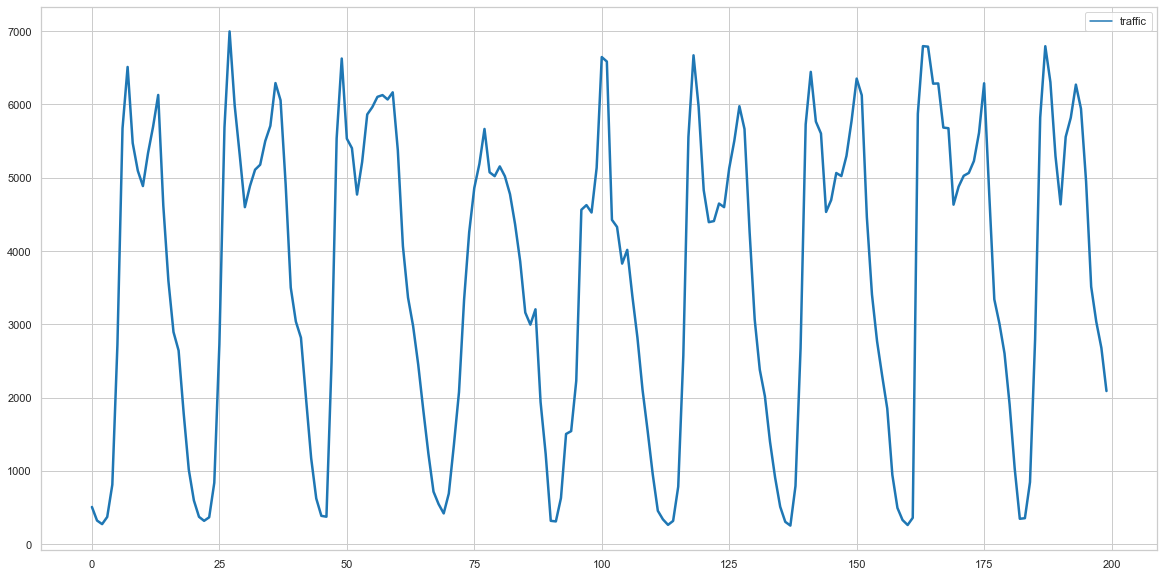

In [21]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")
temp_traffic = traffic[['date_time', 'traffic']]
temp_traffic['date_time'] = pd.to_datetime(temp_traffic['date_time'])
sns.lineplot(data=temp_traffic[:200],  palette="tab10", linewidth=2.5)

## Data Transformations

In our analysis of traffic jams in the city, we wanted to extract as much information as possible from the proposed variables. 
We decided to extract information from the primary variables as follows:
- _date_time_ -> From this variable we extracted information about the _year_, _month_, _day_ of the week and _hour_. We decided not to decode each hour into a zero-one variable, but to make 6 hour intervals dividing our day into 4 equal parts. This is justified because for these 4 parts the traffic variable differs significantly due to sleeping hours and working and commuting hours. Additionally, we decided to add a variable informing whether it is currently the weekend. 
- _weather_detailed_ -> For this variable, we considered to create an ordinal variable from the presented descriptions of the atmospheric phenomena observed on the road. We established 4 levels (from the worst conditions to sufficiently favourable conditions). Level 0 means fatal conditions, 1 poor, 2 moderate and 3 good.
- _weather_general_ -> For this nominal variable, we decoded all levels into zero-one variables and checked which weather types have a variance close to zero. For such variables we attached them to other equally thematically similar categories (Smoke -> Fog and Squall -> Rain)

In [28]:
def dayFromDate(traffic):
    traffic['date_time'] = pd.to_datetime(traffic['date_time'])
    traffic['hour'] = traffic.date_time.dt.hour
    traffic['hour_interval'] = pd.cut(traffic.hour, bins = [-1,6,12,18,24], labels = ['0-6','6-12', '12-18', '18-24'])
    
    
    
    traffic['day'] = traffic.date_time.dt.day_of_week 
    
    traffic['is_weekend'] = np.where(traffic.day.isin([5, 6]), 1, 0)
    traffic['month'] = traffic.date_time.dt.month

    traffic['tmp'] = range(0,len(traffic.hour))
    traffic['year'] = traffic.date_time.dt.year
    t1 = pd.get_dummies(traffic['month'])
    t1['tmp'] = range(0,len(traffic.month))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['hour_interval'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['hour'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp'])

    t1 = pd.get_dummies(traffic['day'])
    t1['tmp'] = range(0,len(traffic.hour))
    traffic = pd.merge(traffic, t1, on = ['tmp']).drop(columns = ['tmp'])
    return(traffic)

def ordinal_whether(traffic):
    traffic['ordinal_weather'] = np.where(traffic.weather_detailed.isin(['fog', 'freezing rain', 'heavy intensity rain','heavy snow','proximity thunderstorm',
                                 'proximity thunderstorm with drizzle', 'proximity thunderstorm with rain', 'sleet', 'squalls',
                                 'thunderstorm', 'thunderstorm with drizzle', 'thunderstorm with heavy rain', 'thunderstorm with light drizzle',
                                  'thunderstorm with light rain', 'thunderstorm with rain', 'very heavy rain']), 0, #fatal
                                 np.where(traffic.weather_detailed.isin(['drizzle','haze', 'heavy intensity drizzle','light intensity drizzle','light intensity shower rain',
                                 'light rain', 'light rain and snow', 'light shower snow', 'light snow','mist', 'moderate rain', 'shower drizzle',
                                  'shower snow', 'smoke', 'snow', ]), 1, #poor
                                 np.where(traffic.weather_detailed.isin(['broken clouds','few clouds', 'overcast clouds', 'proximity shower rain',
                                 ]), 2, #moderate
                                 np.where(traffic.weather_detailed.isin(['scattered clouds', 'sky is clear', ]), 3, 99 )))) #good
    return (traffic)
    
def weather_dummies(traffic):
    t1 = pd.get_dummies(traffic['weather_general'])
    t1['tmp'] = range(0,len(traffic.weather_detailed))
    traffic['tmp'] = range(0,len(traffic.weather_detailed))
    traffic = pd.merge(traffic, t1, on = ['tmp'])
    traffic['Fog'] = traffic['Fog'] + traffic['Smoke']
    traffic['Rain'] = traffic['Rain'] + traffic['Squall']
    traffic = traffic.drop(columns = ['Smoke', 'Squall', 'tmp']) 
    return(traffic)

def weather_dummies_test(traffic):
    t1 = pd.get_dummies(traffic['weather_general'])
    t1['tmp'] = range(0,len(traffic.weather_detailed))
    traffic['tmp'] = range(0,len(traffic.weather_detailed))
    traffic = pd.merge(traffic, t1, on = ['tmp'])
    traffic['Fog'] = traffic['Fog'] + traffic['Smoke']
    traffic['Rain'] = traffic['Rain'] #+ traffic['Squall']
    traffic = traffic.drop(columns = ['Smoke',  'tmp']) # 'Squall',
    return(traffic)

def outliers_correction(traffic):

    traffic.temperature.loc[(traffic.temperature < -30)] = traffic.groupby(by = ['month']).mean().temperature[1]
    traffic.rain_mm.loc[traffic.rain_mm > 1000] = traffic.rain_mm.loc[traffic.rain_mm < 1000].max()
    return (traffic)

traffic = dayFromDate(traffic)
traffic = ordinal_whether(traffic)
traffic = weather_dummies(traffic)
traffic = outliers_correction(traffic)

traffic.rename(columns={'1_x':'January', '2_x':'February', '3_x':'March', '4_x':'April',
                       '5_x':'May','6_x':'June','7_x':'July', '8_x':'August','9_x':'September',
                       '10_x':'November', '11_x':'October', '12_x':'December', '0_x':'Hour_0',
                       '1_y':'Hour_1','2_y':'Hour_2','3_y':'Hour_3','4_y':'Hour_4',
                       '5_y':'Hour_5','6_y':'Hour_6','7_y':'Hour_7','8_y':'Hour_8',
                       '9_y':'Hour_9','10_y':'Hour_10','11_y':'Hour_11','12_y':'Hour_12',
                       13:'Hour_13',14:'Hour_14',15:'Hour_15',16:'Hour_16',
                       17:'Hour_17',18:'Hour_18',19:'Hour_19',20:'Hour_20',
                       21:'Hour_21',22:'Hour_22',23:'Hour_23','0_y':'Monday',
                       1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)

traffic = traffic[traffic['traffic'] != 0]
traffic = traffic[traffic['snow_mm'] == 0]
traffic = traffic[traffic['rain_mm'] == 0]
traffic = traffic.drop(columns = ['date_time', 'weather_general', 'weather_detailed', 
                                  'month', 'year', 'day', 'hour', 'rain_mm','snow_mm','hour_interval'])

train_x, test_x, train_y, test_y = train_test_split(traffic.loc[:,traffic.columns!='traffic'], traffic.traffic, test_size=0.15, random_state=50)

## Model Estimation

In [29]:
def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)
 
    param = {
        'objective': 'regression',
        'metric': {'l2','l1'},
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 4096),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'task': 'train', 
        'boosting': 'gbdt',
        'verbose': -1
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    mape = sklearn.metrics.mean_absolute_percentage_error(test_y, preds)
    return mape
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-06-03 19:44:52,159] A new study created in memory with name: no-name-615c2cbe-c9b4-42e5-8289-ecd823c0c6ab
[I 2022-06-03 19:44:52,869] Trial 0 finished with value: 0.23823356543699167 and parameters: {'n_estimators': 498, 'learning_rate': 0.16949941728766382, 'num_leaves': 2337, 'max_depth': 7}. Best is trial 0 with value: 0.23823356543699167.
[I 2022-06-03 19:44:52,979] Trial 1 finished with value: 0.7022272618579487 and parameters: {'n_estimators': 249, 'learning_rate': 0.018782370452381823, 'num_leaves': 1019, 'max_depth': 2}. Best is trial 0 with value: 0.23823356543699167.
[I 2022-06-03 19:44:53,248] Trial 2 finished with value: 0.32176762372198964 and parameters: {'n_estimators': 589, 'learning_rate': 0.04563929297112498, 'num_leaves': 3416, 'max_depth': 3}. Best is trial 0 with value: 0.23823356543699167.
[I 2022-06-03 19:44:53,676] Trial 3 finished with value: 0.4336276026961985 and parameters: {'n_estimators': 156, 'learning_rate': 0.014979841459681521, 'num_leaves': 13

[I 2022-06-03 19:45:16,149] Trial 32 finished with value: 0.24320510944651771 and parameters: {'n_estimators': 324, 'learning_rate': 0.30542670908376623, 'num_leaves': 2659, 'max_depth': 7}. Best is trial 28 with value: 0.23247702339086065.
[I 2022-06-03 19:45:16,804] Trial 33 finished with value: 0.28487156319625523 and parameters: {'n_estimators': 579, 'learning_rate': 0.7296394069657818, 'num_leaves': 1967, 'max_depth': 6}. Best is trial 28 with value: 0.23247702339086065.
[I 2022-06-03 19:45:17,466] Trial 34 finished with value: 0.2511125256096921 and parameters: {'n_estimators': 769, 'learning_rate': 0.158209956062602, 'num_leaves': 27, 'max_depth': 6}. Best is trial 28 with value: 0.23247702339086065.
[I 2022-06-03 19:45:18,654] Trial 35 finished with value: 0.27417882724553805 and parameters: {'n_estimators': 663, 'learning_rate': 0.526509201902353, 'num_leaves': 1114, 'max_depth': 8}. Best is trial 28 with value: 0.23247702339086065.
[I 2022-06-03 19:45:19,779] Trial 36 finishe

[I 2022-06-03 19:45:47,254] Trial 65 finished with value: 0.23992652187431943 and parameters: {'n_estimators': 355, 'learning_rate': 0.3244766076187665, 'num_leaves': 1930, 'max_depth': 6}. Best is trial 28 with value: 0.23247702339086065.
[I 2022-06-03 19:45:48,143] Trial 66 finished with value: 0.24035238934542486 and parameters: {'n_estimators': 443, 'learning_rate': 0.08728066310083887, 'num_leaves': 2669, 'max_depth': 8}. Best is trial 28 with value: 0.23247702339086065.
[I 2022-06-03 19:45:49,348] Trial 67 finished with value: 0.2558985178620135 and parameters: {'n_estimators': 893, 'learning_rate': 0.4832026659653348, 'num_leaves': 1223, 'max_depth': 7}. Best is trial 28 with value: 0.23247702339086065.
[I 2022-06-03 19:45:50,145] Trial 68 finished with value: 0.23850617023061949 and parameters: {'n_estimators': 832, 'learning_rate': 0.18458599617900323, 'num_leaves': 1653, 'max_depth': 5}. Best is trial 28 with value: 0.23247702339086065.
[I 2022-06-03 19:45:50,428] Trial 69 fi

[I 2022-06-03 19:46:26,332] Trial 98 finished with value: 0.2536040064200177 and parameters: {'n_estimators': 927, 'learning_rate': 0.06008855981006009, 'num_leaves': 3964, 'max_depth': 8}. Best is trial 88 with value: 0.23167092630486955.
[I 2022-06-03 19:46:28,172] Trial 99 finished with value: 0.24846857605674105 and parameters: {'n_estimators': 975, 'learning_rate': 0.04758848839218818, 'num_leaves': 3435, 'max_depth': 8}. Best is trial 88 with value: 0.23167092630486955.


Number of finished trials: 100
Best trial: {'n_estimators': 965, 'learning_rate': 0.10694152991211521, 'num_leaves': 3706, 'max_depth': 8}


MAPE: 23.1671%
MAE: 270.00986422509146


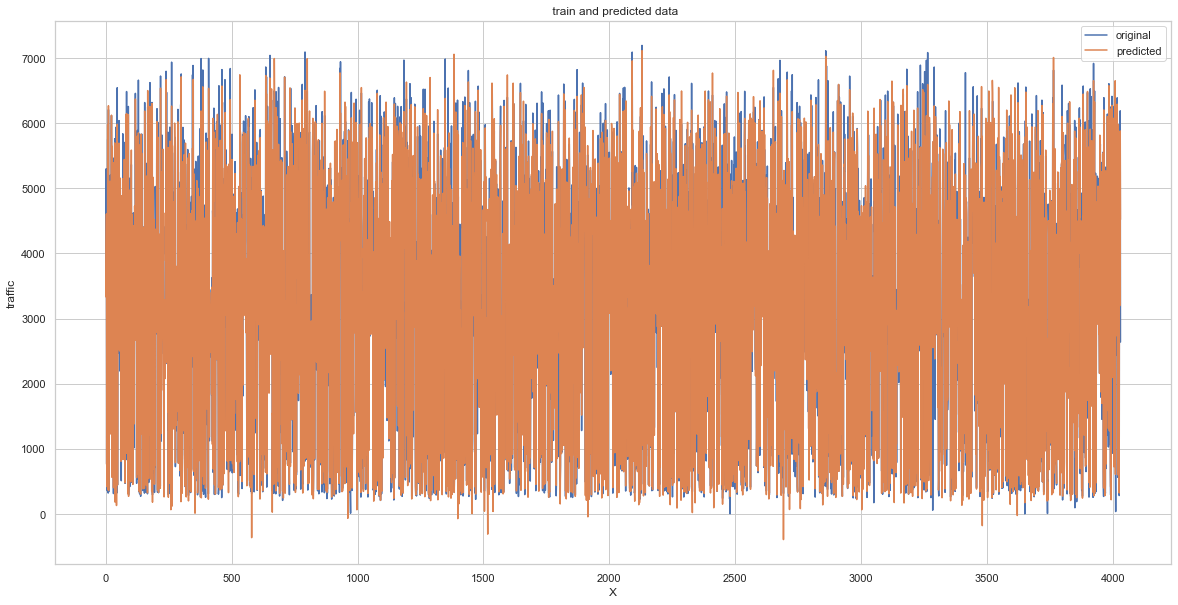

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

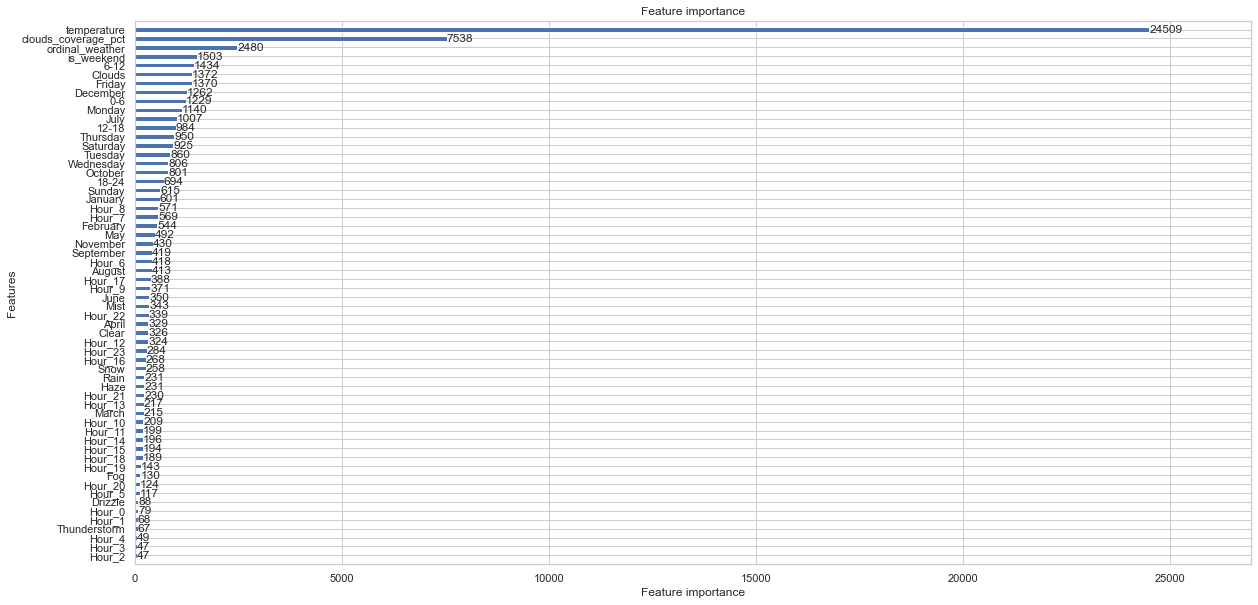

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'n_estimators': study.best_trial.params['n_estimators'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'objective': 'regression',
    'num_leaves': study.best_trial.params['num_leaves'],
    'max_depth' : study.best_trial.params['max_depth'],
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(train_x, train_y)


model = lgb.train(params,
                 train_set=lgb_train)
                 #valid_sets=y_train,
                 #early_stopping_rounds=30)


lgm_pred = model.predict(test_x)

print(f'MAPE: {round(mean_absolute_percentage_error(test_y, lgm_pred) * 100, 4)}%')
print(f'MAE: {mean_absolute_error(test_y, lgm_pred)}')

x_ax = range(len(test_y))
plt.figure(figsize=(20, 10))
plt.plot(x_ax, test_y, label="original")
plt.plot(x_ax, lgm_pred, label="predicted")
plt.title(" train and predicted data")
plt.xlabel('X')
plt.ylabel('traffic')
plt.legend(loc='best',fancybox=True, shadow=False)
plt.grid(True)
plt.show()  

lgb.plot_importance(model, height=.5)


### Test set loading, transformation and prediction

In [31]:
traffic_test = pd.read_csv('traffic_test.csv')

traffic_test = dayFromDate(traffic_test)
traffic_test = ordinal_whether(traffic_test)
traffic_test = weather_dummies_test(traffic_test)
traffic_test = outliers_correction(traffic_test)

traffic_test = traffic_test.drop(columns = ['date_time', 'weather_general', 'weather_detailed', 
                                  'month', 'year', 'day', 'hour', 'rain_mm','snow_mm','hour_interval'])

traffic_test.rename(columns={'1_x':'January', '2_x':'February', '3_x':'March', '4_x':'April',
                       '5_x':'May','6_x':'June','7_x':'July', '8_x':'August','9_x':'September',
                       '10_x':'November', '11_x':'October', '12_x':'December', '0_x':'Hour_0',
                       '1_y':'Hour_1','2_y':'Hour_2','3_y':'Hour_3','4_y':'Hour_4',
                       '5_y':'Hour_5','6_y':'Hour_6','7_y':'Hour_7','8_y':'Hour_8',
                       '9_y':'Hour_9','10_y':'Hour_10','11_y':'Hour_11','12_y':'Hour_12',
                       13:'Hour_13',14:'Hour_14',15:'Hour_15',16:'Hour_16',
                       17:'Hour_17',18:'Hour_18',19:'Hour_19',20:'Hour_20',
                       21:'Hour_21',22:'Hour_22',23:'Hour_23','0_y':'Monday',
                       1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)

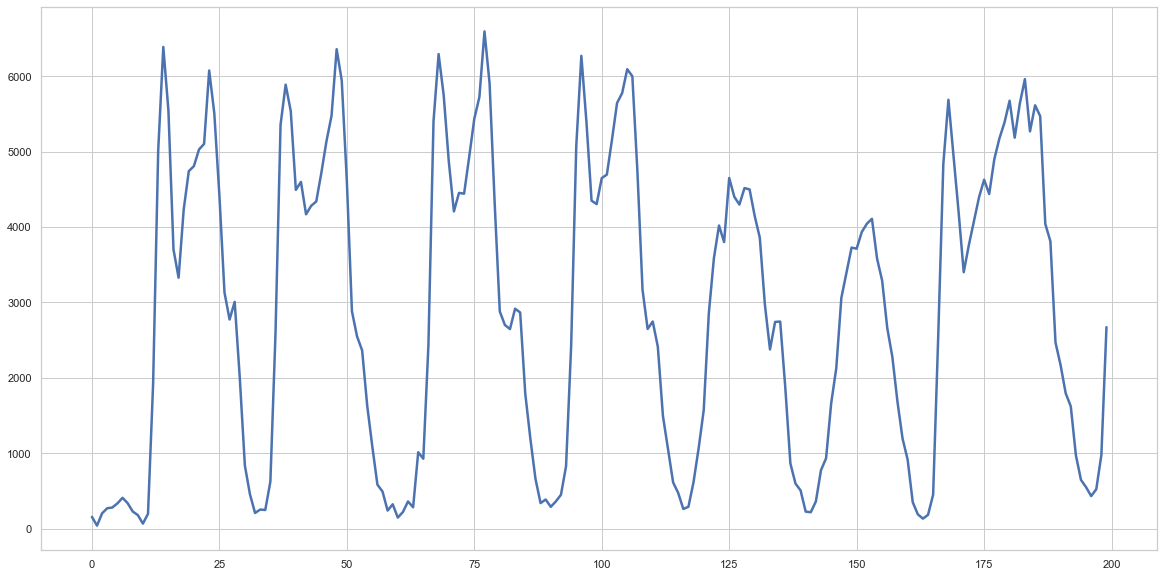

In [32]:
lgm_pred = model.predict(traffic_test)
result = [x if x > 0 else x * (-1) for x in lgm_pred]
sns.set(rc = {'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")
sns.lineplot(data=result[:200],  palette="tab10", linewidth=2.5)
# Save results
submission = result
pd.DataFrame(submission).to_csv("final_results_reg.csv", header = None, index = None)